<a href="https://colab.research.google.com/github/aggelospsiris/Generic-Algorithm-feature-selection/blob/main/Genetic_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()
import re
import numpy as np
import random
from textwrap import indent
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.stats as ss


***Β1***

**α,β)**Για την δημιουργια του αρχικου πληθυσμου φτιαχνω τυχαια διανυσματα που αποτελουνται απο 0 και 1 μηκους οσο ειναι και οι λεξεις του λεξικου δηλαδη 8520
Ο αριθμος αυτων των διανυσματων δηλαδη των διαφορετικων ατομων του πληθησμου  θα ειναι 20 και μετα 200 αναλογα με το τι ζητηται σε καθε πειραμα

**γ)**Για την διαδικασια επιδιορθωσης καθε ατομο δημιουργειτε τυχαια επομενως εχει περιπου το ιδιο αριθμο απο 0 και 1 αρα δεν ειναι καλη πρακτικη η απόρριψη της μη νόμιμης λύσης από τον πληθυσμό και αντικατάστασής της από κάποιο
άλλο άτομο (τυχαία ή με ελιτισμό) καθως ολα τα ατομα ειναι πολυ παρομια.
Αυτη η πρακτικη που μου εδωσε τα καλυτερα αποτελεσματα ειναι ο συνδυασμος επιδιορθωσεις με εφαρμογη ποινης.Αρχικα εφαρμοσα μονο την εφαρμογη ποινης με αποτελεσματα score 1 με 1.5 στα 8.5.Αφοτου εφαρμοσα και επιδιορθωση τα score εφτασαν περιπου 5 στα 8.5, πραγμα λογικο αφου δεν αφηνω τα παντα στην τυχη αλλα επιδιορθωνω τα διανυσματα να εχουν αριθμο ασων πιο κοντα στο 1000 και οχι κοντα στο 4.000 οπως ειχαν πριν.

**δ)** H συναρτηση καταλληλοτητας καταλληλοτητας ειναι συνδυασμος του μεσου ορου των τιμων του tf-idf για τα ατομα που εχουν επιλεγει αφαιροντας ως penaldy 
την απολυτη τιμη |1000 - (συνολικοι ασοι)|/8520.Μαλιστα αν το 1000 - (συνολικοι ασοι) ειναι θετικο τοτε το penaldy διπλασιαζεται για να υπαρξει μεγαλυτερη ποινη
Τελος για να υπρχει σωστη αναλογια μεταξυ μ.ο και πεναλντι γινονται οι αναλογες αλλαγες στις τιμες αυτες.



In [3]:
def fitness_function(pop):
  
  for p in pop:
   a = numpy.array(p)
   if np.count_nonzero(a == 1) > 1000 :
      for _ in range(np.count_nonzero(a == 1)):
        r = random.randint(0, 8249)
        if p[r] == 1 :
          p[r] = 0
   if  np.count_nonzero(a == 1) < 1000:
      for _ in range(np.count_nonzero(a == 1)):
        r = random.randint(0, 8249)
        if p[r] == 0 :
          p[r] = 1
  
  # count the ones in each bitstring 
  # the count is the number of words in each different dictionary
  # i am using this 'penaldy = (1000-count)/8520' so the longest the distance between the number of words the biggest the penaldy
  #also if the the count is less than 1000  then the penaldy is equal -2*penaldy 
  count = 0
  count_list = []
  penaldy_list = []
  for p in pop:
    for i in p:
      if i == 1:
        count = count + 1
    penaldy = (1000-count)/8520
    if penaldy > 0 :
      penaldy  = -2 * penaldy 
    penaldy_list.append(penaldy)
    penaldy = 0  
    count = 0 
  
  newlines = []
  with open('/content/sample_data/train-data.dat', 'r') as f:
      lines = f.readlines()
      for line in lines:
          # in every line erase any occurance that starts with < and ends with > with
          newline = re.sub("\<[^>]*\>", "", line)
          newlines.append(newline)


  #using the count vectorizer
  count = CountVectorizer()
  word_count=count.fit_transform(newlines)
 
  tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(word_count)
  df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"])
  #Proceeding to the TF-IDF transformation.
  #tfidf
  tf_idf_vector=tfidf_transformer.transform(word_count)
  feature_names = count.get_feature_names()
  first_document_vector=tf_idf_vector[1]
  df_tfifd= pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])

  #the evalution list contains the mean value  of the words that have been chosen
  #c is the sum count of all the words that have been chosen
  #evaluation is the sum count of the value of each word bases on tf-idf table 
  c = 0
  counter = 0
  evaluation = 0
  evaluation_list = []
  for individual in pop:
      for chromosoma in individual:
        if chromosoma == 1:
          try:
            evaluation += df_tfifd.loc[str(counter),'tfidf']
          except:
            continue
          c += 1
        counter += 1
      counter = 0
      evaluation_list.append((evaluation/c))
      c = 0
      evaluation = 0

  scores = []
  for p, e in zip(penaldy_list, evaluation_list):
    scores.append(p + 1000*e)
  
  #the best eval is the score that has a individual that contains just 1000 so the penaldy is 0
  #and these words are the best 1000 words from the tf-idf table 
  sorted=df_tfifd.sort_values(by='tfidf',ascending=False)
  best_vals = sorted.head(1000)
  mean_best = (best_vals.mean())*1000
  #print("Best possible score:%f" % (mean_best))  
  #best possible score is 8.5
  return scores
    


**Επιλογη**

Τρεχοντας και και τους τρεις τροπους selection καλυτερα αποτελεσματα πηρα απο τουρνου.Η ρουλετα με βαση το κοστος ή την καταταξη επεφτε συνηθως σε τοπικο μεγιστο στις με score περιπου στα 2.5/8.5 ενω το τουρνουα εφτανε παντα πανω απο 4.5/8.5





In [4]:
#I am using tournament_selection because some scores are negative and the roulette wheel works with probabilities that are never negative
# tournament_selection
def tournament_selection(pop, scores, k):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] > scores[selection_ix]:
			selection_ix = ix 
	return pop[selection_ix]

def roulette_selection(pop,scores,n_pop):
  #create the probalitites
  score_sum = 0
  for score in scores:
     score_sum += score
  prob_list = scores/score_sum
  #create the roulette slots
  roulette_slots = []
  roulette_slots.append(0) 
  for i in range(len(prob_list)):
     roulette_slots.append(prob_list[i]+roulette_slots[i])
  #for the 20 different slots check j in which slot is in and return pop[j]
  selected = 0
  rn = random.uniform(0, 1)
  for j in range(n_pop):
    if j == 0 :
      if rn > 0 and rn < roulette_slots[j]:
         selected = j  
    else:
      if rn > roulette_slots[j-1] and rn < roulette_slots[j]:
         selected = j 
  return pop[selected]


def rank_selection(pop,scores,n_pop):
  total_rank = (n_pop + 1) * n_pop /2;#1 + 2 + ... + N = (N + 1) * N / 2
  prob_list = ss.rankdata(scores) / total_rank
  #create the roulette slots
  roulette_slots = []
  roulette_slots.append(0) 
  for i in range(len(prob_list)):
     roulette_slots.append(prob_list[i]+roulette_slots[i])
  #for the 20 different slots check j in which slot is in and return pop[j]
  selected = 0
  rn = random.uniform(0, 1)
  for j in range(n_pop):
    if j == 0 :
      if rn > 0 and rn < roulette_slots[j]:
         selected = j  
    else:
      if rn > roulette_slots[j-1] and rn < roulette_slots[j]:
         selected = j 
  return pop[selected] 
         

**Crossover**

Η ομοιορφη διασταβρωση ειχε τα χειροτερα αποτεσματα αφου κολαγε τις περισσοτερες φορες σρτην πρωτη γενια.Η διασταυρωση μονο σημειου μου εδινε κλαυτερα αποτελεσματα απο την ομοιομορφη δηλαδη κοντα στο 3.5/8.5.Ωστοσο τα καλυτερα αποτελεσματα τα πηρα με διασταθρωση πολλαπλου σημειου

In [5]:
#single_point_crossover
def single_point_crossover(p1, p2, r_cross):
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		p1 = p1[:pt] + p2[pt:]
		p2 = p2[:pt] + p1[pt:]
	return [p1, p2]

def multi_point_crossover(p1, p2, r_cross,points):
  #points represends in ho many points are we going to crossover
  for _ in range(points):
    p1,p2 = single_point_crossover(p1,p2,r_cross)
  return [p1,p2]   

def uniform_crossover(p1,p2,n_bits):
  P = [random.uniform(0,1) for _ in range(n_bits)]
  for i in range(n_bits):
    if P[i]<0.5:
      temp = p1[i]
      p1[i] = p2[i]
      p2[i] = temp
    return [p1,p2]

**Mutation**

Μεταλλαξη με ελιτισμο.Τσεκαρει πριν κανει μεταλλαξη αν το score του ατομου μετα το crossover ειναι μικροτερο του καλυτερου score μεχρι εκεινη την στιγμη και προχαραει στην μεταλλαξη.Αν οχι τοτε δεν προχωρα.Δινει λιγο καληυτερα αποτελεσματα γιατι δεν χαλαει το καλυτερο ατομο ωστοσο περνει πολυ περισσοτερο χρονο στα τρεξιματα για αυτο χρησιμοποιω απλο mutation

In [6]:
# mutation operator
def mutation_with_elitism(bitstring, r_mut,best_eval):
  if fitness_function([bitstring]) < best_eval:
   for i in range(len(bitstring)):
		 # check for a mutation
     if np.random.rand() < r_mut:
		 	# flip the bit
       bitstring[i] = 1 - bitstring[i]
   return bitstring

def mutation(bitstring, r_mut):
   for i in range(len(bitstring)):
		 # check for a mutation
     if np.random.rand() < r_mut:
		 	# flip the bit
       bitstring[i] = 1 - bitstring[i]
   return bitstring


In [7]:
def genetic_algorithm(fitness_function,n_bits,n_pop,n_iter,r_cross, r_mut):
 # initial population of random bitstring
 pop = [np.random.randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
 # keep track of best solution
 best, best_eval = 0,0
 # enumerate generations
 #count counts the generation that the best individual dont imporove
 count = 0
 performance = []
 for gen in range(n_iter):  
   if count < 1000:
	    # evaluate all candidates in the population
		  scores = fitness_function(pop)
		  # check for new best solution
		  for i in range(n_pop):
			  if scores[i] > best_eval:
					#if the new score is not improving more than 0.01% turn the count into 200 so the for loop stops
				  if scores[i] < best_eval + best_eval*0.01:
				  	count = 1000
				  best, best_eval = pop[i], scores[i]
				  print("Generation:%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
			    #if the score of the best indivdual  improves make count 0 again and restart counting till there is no improvement until 200 generations 
				  count = 0
			  else:
					#else if there is no improvement count ++
				  count = count + 1 
      # select parents
			#tournament_selection
		  selected = [tournament_selection(pop, scores,int(n_pop/4)) for _ in range(n_pop)]
			#roulette_selection
		  #selected = [roulette_selection(pop,scores,n_pop) for _ in range(n_pop)]
			#rank_selection
		  #selected = [rank_selection(pop,scores,n_pop) for _ in range(n_pop)]
			# create the next generation
		  children = list()
		  for i in range(0, n_pop, 2):
			  # get selected parents in pairs
			  p1, p2 = selected[i], selected[i+1]
			  # crossover and mutation
			  #for c in single_point_crossover(p1, p2, r_cross):
			  for c in multi_point_crossover(p1, p2, r_cross,10):	
			  #for c in uniform_crossover(p1,p2,n_bits):
				  # mutation
				  mutation(c, r_mut)
				  # store for next generation
				  children.append(c)
		  # replace population
		  pop = children
		  performance.append(best_eval)
   else :
    break
 return [best, best_eval,performance]



Generation:0, new best f([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,

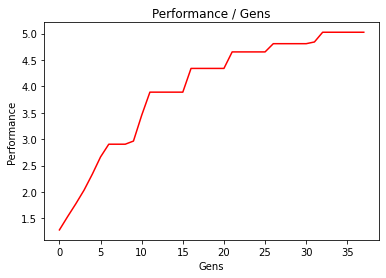

In [12]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
#for the plot
#keep the best results from these 10 runs
best_overall_score = 0
best_overall_individual = []
best_scores = []
best_gens = []
# define the total iterations
n_iter = 2000
# bits
n_bits = 8520
n_pop = 200
# crossover rate
r_cross = 0.6
# mutation rate
r_mut = 0.00
# perform the genetic algorithm search
best, score ,performance = genetic_algorithm(fitness_function,n_bits,n_pop,n_iter,r_cross, r_mut)
print('Done!')
print('f(%s) = %f' % (best, score))

# plot the performance/gens each time
import matplotlib.pyplot as plt
plt.title("Performance / Gens")
plt.xlabel("Gens")
plt.ylabel("Performance")
plt.plot(performance, color="red")
plt.show()


In [13]:
if score > best_overall_score:
  best_overall_score = score
  best_overall_individual = best


In [14]:
print(best_overall_score)

5.025233468586848


In [25]:
#create the new dictionary
i = 0 
new_vocab = []
for k in best:
  if k == 1:
    new_vocab.append(i)
  i = i + 1


Fold : 0
CE : 0.36391085386276245
MSE : 0.11577028036117554
Acc_CE : 0.2822531759738922
Acc_MSE : 0.26529374718666077
---------------------------------------
Fold : 1
CE : 0.3608191907405853
MSE : 0.11468403786420822
Acc_CE : 0.3115151524543762
Acc_MSE : 0.2824242413043976
---------------------------------------
Fold : 2
CE : 0.358979195356369
MSE : 0.1155029907822609
Acc_CE : 0.28545454144477844
Acc_MSE : 0.2672727406024933
---------------------------------------
Fold : 3
CE : 0.3680116534233093
MSE : 0.11752983182668686
Acc_CE : 0.290909081697464
Acc_MSE : 0.2751515209674835
---------------------------------------
Fold : 4
CE : 0.3617730140686035
MSE : 0.1160828024148941
Acc_CE : 0.28787878155708313
Acc_MSE : 0.2709091007709503
---------------------------------------
Accuracy_MSE:  0.2722102701663971
Accuracy_CE:  0.2916021466255188
CE is :  0.3626987814903259
MSE is :  0.11591398864984512


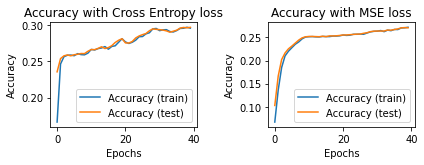

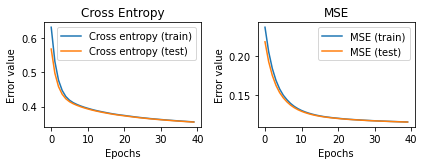

In [27]:
import tensorflow as tf
tf.test.gpu_device_name()

import re
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from sklearn import preprocessing
from sklearn.model_selection import KFold
from keras import backend as K
import keras
from tensorflow import keras
from matplotlib import pyplot
from tensorflow.keras.callbacks import EarlyStopping

#labels into vectors array
Y_train_labels = np.loadtxt("/content/sample_data/train-label.dat")

#prepare train
newlines = []
with open('/content/sample_data/train-data.dat', 'r') as f:
    lines = f.readlines()
    for line in lines:
        # in every line erase any occurance that starts with < and ends with > with
        newline = re.sub("\<[^>]*\>", "", line)
        newlines.append(newline)

#vocab = list(range(0, 8251))
vocab = new_vocab
vects = []
vect = []
count = 0
i = 0
for line in newlines:
    fraze = line.split()
    fraze = [int(x) for x in fraze]
    for v in vocab:
        for f in fraze:
            if(v == f):
                count = count +1
        vect.append(count)
        count = 0
    vect = np.array(vect)
    #vects.append(np.interp(vect, (vect.min(), vect.max()), (-1, +1)))
    vects.append(vect)
    vect = []

X_train = np.array(vects)
vects = []


def ce_model():
    # Create model
    model = Sequential()
    #input layer with a hidden layer of (i+o)
    model.add(Dense(units = len(X_train[0])+20, activation="relu", input_dim=len(X_train[0])))
  
    #output layer with 20 output neuron cause the classfication classes are 20
    model.add(Dense(units = 20, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=0.05,momentum=0.6, nesterov=False, name="SGD")
    model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    return model
def mse_model():
    # Create model
    model = Sequential()
    #input layer with a hidden layer of (i+o)
    model.add(Dense(units = len(X_train[0])+20, activation="relu", input_dim=len(X_train[0])))

    #output layer with 20 output neuron cause the classfication classes are 20
    model.add(Dense(units = 20, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=0.05,momentum=0.6, nesterov=False, name="SGD")
    model.compile(optimizer=opt,loss=keras.losses.mse, metrics=['accuracy'])
    return model

#c.cross-validation
# Split the data to training and testing data 5-Fold
kfold = KFold(n_splits=5, shuffle=True)
ce_loss = []
mse_loss = []
acc_mse=[]
acc_ce=[]


for i, (train, test) in enumerate(kfold.split(X_train)):

    callback = EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0, patience=5, verbose=0)

    # Fit models
    #CE
    model1=ce_model()
    history_ce = model1.fit(X_train[train], Y_train_labels[train],
                            validation_data=(X_train[train], Y_train_labels[train]),
                            epochs=40, batch_size=200, verbose=0)
    loss_ce, accuracy_ce = model1.evaluate(X_train[test], Y_train_labels[test],verbose=0)
    #MSE
    model2=mse_model()
    history_mse = model2.fit(X_train[train], Y_train_labels[train],
                             validation_data=(X_train[train], Y_train_labels[train]),
                             epochs=40, batch_size=200, verbose=0)
    loss_mse, accuracy_mse = model2.evaluate(X_train[test], Y_train_labels[test],verbose=0)
    
    mse_loss.append(loss_mse)
    acc_ce.append(accuracy_ce)
    acc_mse.append(accuracy_mse)
    ce_loss.append(loss_ce)

    print("Fold :", i)
    print("CE :", loss_ce)
    print("MSE :", loss_mse)
    print("Acc_CE :", accuracy_ce)
    print("Acc_MSE :", accuracy_mse)
    print("---------------------------------------")

#print the mean results
print("Accuracy_MSE: ", np.mean(acc_mse))
print("Accuracy_CE: ", np.mean(acc_ce))
print("CE is : ", np.mean(ce_loss))
print("MSE is : ", np.mean(mse_loss))

#Plots
pyplot.figure(0)
pyplot.subplot(2, 2, 1)
pyplot.plot(history_ce.history['accuracy'], label='Accuracy (train)')
pyplot.plot(history_ce.history['val_accuracy'], label='Accuracy (test)')
pyplot.title("Accuracy with Cross Entropy loss")
pyplot.ylabel("Accuracy")
pyplot.xlabel("Epochs")
pyplot.legend()

pyplot.subplot(2, 2, 2)
pyplot.plot(history_mse.history['accuracy'], label='Accuracy (train)')
pyplot.plot(history_mse.history['val_accuracy'], label='Accuracy (test)')
pyplot.title("Accuracy with MSE loss")
pyplot.ylabel("Accuracy")
pyplot.xlabel("Epochs")
pyplot.legend()
pyplot.tight_layout()
pyplot.show()


# plot the cross entropy loss
pyplot.figure(1)
pyplot.subplot(2, 2, 1)
pyplot.plot(history_ce.history['loss'], label='Cross entropy (train)')
pyplot.plot(history_ce.history['val_loss'], label='Cross entropy (test)')
pyplot.title('Cross Entropy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Error value')
pyplot.legend()

# plot the mse loss
pyplot.subplot(2, 2, 2)
pyplot.plot(history_mse.history['loss'], label='MSE (train)')
pyplot.plot(history_mse.history['val_loss'], label='MSE (test)')
pyplot.title('MSE')
pyplot.xlabel('Epochs')
pyplot.ylabel('Error value')
pyplot.legend()
pyplot.tight_layout()
pyplot.show()